In [1]:
# from dask.distributed import Client, LocalCluster
# import logging

# cluster = LocalCluster(
#     n_workers=10,
#     threads_per_worker=8,
#     silence_logs=logging.DEBUG
# )

# client = Client(cluster, heartbeat_interval=10000)

# print(client.dashboard_link)

In [3]:
import afqinsight as afqi
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from sklearn.base import clone
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.linear_model import ElasticNetCV

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

print(afqi.__version__)

0.2.9.dev460469908


In [4]:
X, y, groups, columns, subjects, classes = afqi.load_afq_data(
    "../data/raw/camcan_data",
    target_cols=["age"],
    index_col="Observations"
)

In [5]:
print(X.shape)
print(y.shape)
print(len(subjects))

(641, 3600)
(652,)
641


In [6]:
df_y = pd.read_csv("../data/raw/camcan_data/subjects.csv")
df_y.head()
df_y = df_y[["Observations", "age"]]
df_y = df_y.set_index("Observations", drop=True)
df_subs = pd.DataFrame(index=subjects)
df_subs = df_subs.merge(df_y, how="left", left_index=True, right_index=True)
y = df_subs["age"].astype(np.float64).values
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]

In [7]:
print(X.shape)
print(y.shape)

(640, 3600)
(640,)


In [8]:
len(groups)

36

(array([26., 58., 72., 68., 76., 64., 71., 74., 86., 45.]),
 array([18., 25., 32., 39., 46., 53., 60., 67., 74., 81., 88.]),
 <BarContainer object of 10 artists>)

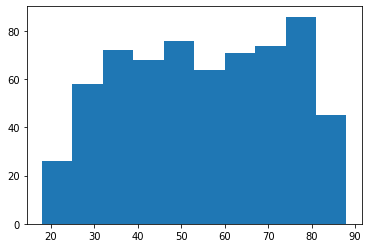

In [9]:
plt.hist(y)

In [10]:
np.median(y)

55.0

In [14]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   target_transform_func=None,
                   target_transform_inverse_func=None,
                   n_estimators=10,
                   trim_nodes=0,
                   square_features=False):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)
        
    if trim_nodes > 0:
        grp_mask = np.zeros_like(groups[0], dtype=bool)
        grp_mask[trim_nodes:-trim_nodes] = True
        X_mask = np.concatenate([grp_mask] * len(groups))

        groups_trim = []
        start_idx = 0
        
        for grp in groups:
            stop_idx = start_idx + len(grp) - 2 * trim_nodes
            groups_trim.append(np.arange(start_idx, stop_idx))
            start_idx += len(grp) - 2 * trim_nodes
            
        X_trim = X[:, X_mask]
    elif trim_nodes == 0:
        groups_trim = [grp for grp in groups]
        X_trim = np.copy(X)
    else:
        raise ValueError("trim_nodes must be non-negative.")
        
    if square_features:
        _n_samples, _n_features = X_trim.shape
        X_trim = np.hstack([X_trim, np.square(X_trim)])
        groups_trim = [np.concatenate([g, g + _n_features]) for g in groups_trim]
    
    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    pipe_skopt = afqi.pipeline.make_base_afq_pipeline(
        imputer_kwargs={"strategy": "median"},
        power_transformer=power_transformer,
        scaler="standard",
        estimator=ElasticNetCV,
        estimator_kwargs={
            "verbose": 0,
            "n_alphas": 50,
            "l1_ratio": np.linspace(0.01, 1, 10),
            "cv": 3,
            "n_jobs": 28,
            "max_iter": 500,
        },
        verbose=0,
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
        },
        target_transform_func=target_transform_func,
        target_transform_inverse_func=target_transform_inverse_func,
    )
    
    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_trim, y_fit)):
        start = datetime.now()

        X_train, X_test = X_trim[train_idx], X_trim[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]

        pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_mae": median_absolute_error(y_test, pipe_skopt.predict(X_test)),
            "train_mae": median_absolute_error(y_train, pipe_skopt.predict(X_train)),
            "test_r2": r2_score(y_test, pipe_skopt.predict(X_test)),
            "train_r2": r2_score(y_train, pipe_skopt.predict(X_train)),
        }
        
        if ensembler is None:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["coefs"] = pipe_skopt.named_steps["estimate"].regressor_.coef_
                cv_results[cv_idx]["alpha"] = pipe_skopt.named_steps["estimate"].regressor_.alpha_
                cv_results[cv_idx]["l1_ratio"] = pipe_skopt.named_steps["estimate"].regressor_.l1_ratio_
            else:
                cv_results[cv_idx]["coefs"] = pipe_skopt.named_steps["estimate"].coef_
                cv_results[cv_idx]["alpha"] = pipe_skopt.named_steps["estimate"].alpha_
                cv_results[cv_idx]["l1_ratio"] = pipe_skopt.named_steps["estimate"].l1_ratio_
        else:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["coefs"] = [
                    est.coef_ for est
                    in pipe_skopt.named_steps["estimate"].regressor_.estimators_
                ]
                cv_results[cv_idx]["alpha"] = [
                    est.alpha_ for est
                    in pipe_skopt.named_steps["estimate"].regressor_.estimators_
                ]
                cv_results[cv_idx]["l1_ratio"] = [
                    est.l1_ratio_ for est
                    in pipe_skopt.named_steps["estimate"].regressor_.estimators_
                ]
            else:
                cv_results[cv_idx]["coefs"] = [
                    est.coef_ for est
                    in pipe_skopt.named_steps["estimate"].estimators_
                ]
                cv_results[cv_idx]["alpha"] = [
                    est.alpha_ for est
                    in pipe_skopt.named_steps["estimate"].estimators_
                ]
                cv_results[cv_idx]["l1_ratio"] = [
                    est.l1_ratio_ for est
                    in pipe_skopt.named_steps["estimate"].estimators_
                ]
        
        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [15]:
results = {}

In [16]:
trim_nodes = 0

results[f"bagging_target_transform_pure_lasso_trim{trim_nodes}"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False,
    shuffle=False,
    target_transform_func=np.log, target_transform_inverse_func=np.exp,
    trim_nodes=trim_nodes, square_features=False,
)

results[f"bagging_pure_lasso_trim{trim_nodes}"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False,
    shuffle=False,
    trim_nodes=trim_nodes, square_features=False,
)

/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013949659440961604, tolerance: 0.006920075196833256
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0047174574601465125, tolerance: 0.0034997349507629133
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001639234546092938, tolerance: 0.0013273393079186277
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of 

CV index [  0], Elapsed time:  0:01:56.881981


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002106472095748435, tolerance: 0.0014847404937218423
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049757471318143676, tolerance: 0.0014847404937218423
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004708233436114151, tolerance: 0.0014847404937218423
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of

CV index [  1], Elapsed time:  0:02:04.423735


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022187003664351224, tolerance: 0.001352066411095541
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003896000066772487, tolerance: 0.003290027987729555
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003652617065285746, tolerance: 0.003290027987729555
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

CV index [  2], Elapsed time:  0:01:57.745535


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00397151986834321, tolerance: 0.0014915519933969645
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004605839132388878, tolerance: 0.00362612467247302
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004818724155002396, tolerance: 0.00362612467247302
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

CV index [  3], Elapsed time:  0:01:41.601257


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002141109445332301, tolerance: 0.0014522375726059124
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004619520118306575, tolerance: 0.003676028469882621
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041914389637900396, tolerance: 0.003676028469882621
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

CV index [  4], Elapsed time:  0:01:50.762710


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.62274174950653, tolerance: 16.514924340175952
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.837357241480959, tolerance: 5.805166374269006
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.995001850122208, tolerance: 16.514924340175952
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

CV index [  0], Elapsed time:  0:01:49.998942


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.289971429523575, tolerance: 5.51930615835777
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.574710243661684, tolerance: 5.51930615835777
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.19307143387323, tolerance: 5.51930615835777
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

CV index [  1], Elapsed time:  0:01:31.069067


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.788522679042217, tolerance: 5.245524340175954
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.631789678285713, tolerance: 5.565741812865498
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.364248605021203, tolerance: 5.245524340175954
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

CV index [  2], Elapsed time:  0:01:51.214853


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.630159865657333, tolerance: 5.620929032258065
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.953895879658376, tolerance: 5.620929032258065
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.236679142327375, tolerance: 5.620929032258065
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

CV index [  3], Elapsed time:  0:01:54.207169


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.186685281600148, tolerance: 5.507692668621701
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.96973847918889, tolerance: 5.507692668621701
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.620969525591363, tolerance: 6.152783918128654
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

CV index [  4], Elapsed time:  0:01:27.537646


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2137.3632862639856, tolerance: 18.192921875
  positive)


In [17]:
for key, res in results.items():
    test_mae = [cvr["test_mae"] for cvr in res[0].values()]
    train_mae = [cvr["train_mae"] for cvr in res[0].values()]
    test_r2 = [cvr["test_r2"] for cvr in res[0].values()]
    train_r2 = [cvr["train_r2"] for cvr in res[0].values()]

    print(key, "mean MAE", np.mean(test_mae))
    print(key, "std MAE", np.std(test_mae))
    print(key, "mean R2", np.mean(test_r2))
    print(key, "std R2", np.std(test_r2))

bagging_target_transform_pure_lasso_trim0 mean MAE 6.618011920459756
bagging_target_transform_pure_lasso_trim0 std MAE 0.40794582484587755
bagging_target_transform_pure_lasso_trim0 mean R2 0.5808958652025411
bagging_target_transform_pure_lasso_trim0 std R2 0.0882213773099808
bagging_pure_lasso_trim0 mean MAE 5.738878521665048
bagging_pure_lasso_trim0 std MAE 0.40844266478124436
bagging_pure_lasso_trim0 mean R2 0.7351360863996961
bagging_pure_lasso_trim0 std R2 0.02535012594260761


In [18]:
with open("camcan_regression_elastic_net.pkl", "wb") as fp:
    pickle.dump(results, fp)